(content:ps_statistics)=
# *Power Spectrum Statistics*

***Authors: James Kuszlewicz, Marc Hon***

Before we dive into analyzing power spectra, we first need to understand the type of statistics that will arise when moving from the time domain into the frequency domain.

To start, we import the necessary libraries for this notebook.

In [1]:
import astropy.units as u
import matplotlib.pyplot as plt
plt.style.use('science')
fs = 18
import numpy as np
import scipy

from astropy.units import cds

cds.enable()

Let's consider a time series having $N$ observations that are comprised of random, white noise.

In [ ]:
N = 2**15
x = np.random.normal(0, np.sqrt(N), N)

dt = 29.4*u.min 
dt = dt.to(u.s).value

t = np.arange(0, len(x)*dt, dt)*u.s

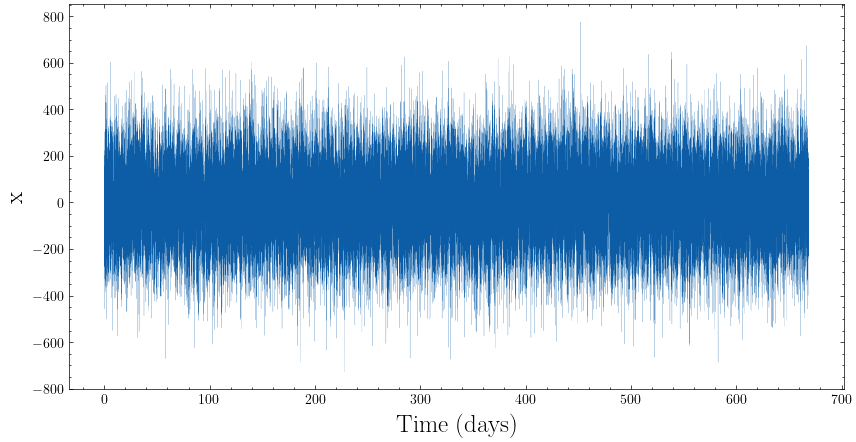

In [2]:
fig = plt.figure(figsize=(10, 5))
plt.plot(t.to(u.d).value, x, lw=0.1);
plt.ylabel(r'x', fontsize=fs);
plt.xlabel(r'Time (days)', fontsize=fs);

Recall that the Fourier transform $X(f)$ describes the frequency ($f$) content of a signal $x(t)$, and has both real and imaginary components:
```{math}
:label: ft
\begin{aligned}
X(f) = \mathcal{F}[x(t)] = \text{Re}[x(t)] + i\text{Im}[x(t)]
\end{aligned}
```

Let's observe what are resulting distributions of these components, computed using `np.fft(x)`.

In [ ]:
fft = np.fft.fft(x)

vals = np.linspace(-5, 5, 1000) # Values at which to evaluate Gaussian PDF

# Frequency bin-width, for normalisation purposes
freq_bw = 1e6 / ((t.max() - t.min())*86400.0)

freq = np.fft.fftfreq(len(x), d=dt) # Taking only positive frequencies

fft_real = np.sqrt(2)*fft.real/len(x) # Divide by length of timeseries to normalise appropriately
fft_imag = np.sqrt(2)*fft.imag/len(x)

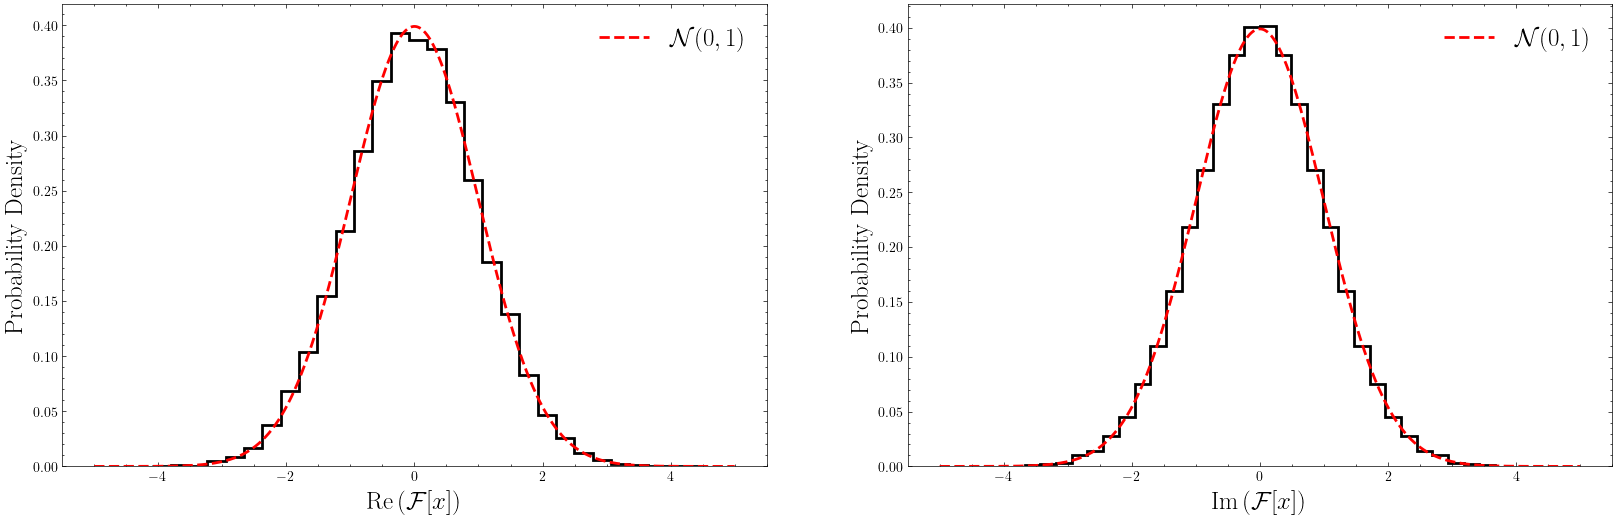

In [3]:
fig, ax = plt.subplots(figsize=(20, 6), nrows=1, ncols=2)
ax[0].hist(fft_real, bins=30, density=True, histtype='step', lw=2, color='k');
ax[0].plot(vals, scipy.stats.norm(loc=0, scale=1).pdf(vals), color='r', linestyle='--', lw=2, label=r'$\mathcal{N}(0, 1)$')
ax[0].set_xlabel(r'$\mathrm{Re}\left(\mathcal{F}[x]\right)$', fontsize=fs);
ax[0].set_ylabel(r'Probability Density', fontsize=fs);
ax[0].legend(loc='best', fontsize=fs);
ax[1].hist(fft_imag, bins=30, density=True, histtype='step', color='k', lw=2);
ax[1].plot(vals, scipy.stats.norm(loc=0, scale=1).pdf(vals), color='r', linestyle='--', lw=2, label=r'$\mathcal{N}(0, 1)$')
ax[1].set_xlabel(r'$\mathrm{Im}\left(\mathcal{F}[x]\right)$', fontsize=fs);
ax[1].set_ylabel(r'Probability Density', fontsize=fs);
ax[1].legend(loc='best', fontsize=fs);


```{important}
Observe the normalization by $\sqrt{2}$  in calculating the FFT components `fft_real` and `fft_imag` above. The FFT computation above provides the root-mean-squared (RMS) amplitude, and so the $\sqrt{2}$ factor is introduced to renormalize the amplitudes to peak-to-peak values. This is such that a sine wave of amplitude $1$ will yield a height of $1$ in the amplitude spectrum.
```
We see that the components of the Fourier transform are normally distributed! Note that this was based off a deliberate choice of the time series having a noise scatter with a variance of $N$.


The **power spectrum** is the squared magnitude of the Fourier transform, and indicates the total amount of variation in the signal at a given frequency. It is simply the sum of the square of the Fourier transform's real and imaginary components:
```{math}
:label: ps
\begin{aligned}
\\ [ \mathcal{F}[x(t)]]^2 = |X(f)|^2 = \text{Re}(x(t))^2 + \text{Im}(x(t))^2.
\end{aligned}
```

What are the statistics that arise from this relation? This is the **sum of squares** of normalized Gaussian random variates, whose statistics are governed by the $\chi^2$ distribution with $n$ degrees of freedom (d.o.f), as given by:
```{math}
:label: chi2
\begin{aligned}
f(x) = \frac{1}{2^{n/2}\Gamma(n/2)}x^{n/2 - 1} \exp\bigg(-\frac{x}{2}\bigg).
\end{aligned}
```

Here, we have $n=2$ from the real and imaginary components of the Fourier transform. Observe how the power is distributed in the following:

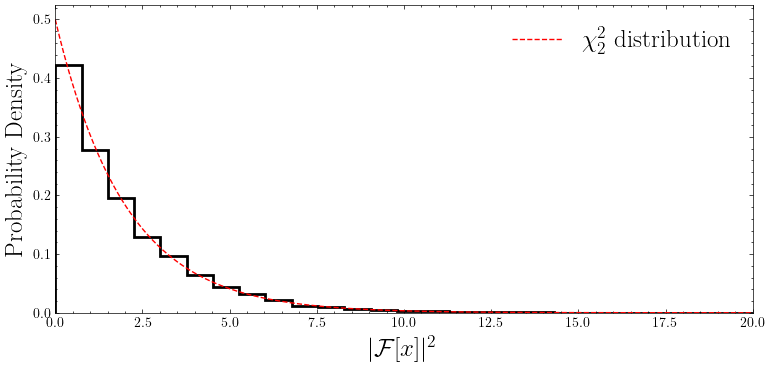

In [4]:
power = 2 * np.abs(fft)**2 / len(x)**2
vals = np.linspace(0, 20, 1000)

plt.figure(figsize=(9, 4))
plt.hist(power, bins=30, histtype='step', density=True, color='k', lw=2);
plt.plot(vals, scipy.stats.chi2(df=2).pdf(vals), color='r', linestyle='--', label=r'$\chi^{2}_{2}$ distribution');
plt.xlabel(r'$|\mathcal{F}[x]|^{2}$', fontsize=fs);
plt.ylabel(r'Probability Density', fontsize=fs);
plt.xlim(0, 20);
plt.legend(loc='best', fontsize=fs);

```{note}
Notice the normalization by 2 when calculating `power` -- again a consequence of obtaining peak-to-peak values.
```
We see that the computed power values do conform to the expected $\chi^2_2$ distribution. Note that this is a special case based on a deliberate choice of __white noise distributed with a variance of $N$__. In reality, the variance of the time series is dictated by the observations themselves.

## Scaling the Statistics

Let's see an example where we let the underlying process of the time series be simply a standard normal instead:

In [ ]:
N = 2**15
x = np.random.normal(0, 1, N)

dt = 29.4*u.min 
dt = dt.to(u.s).value

t = np.arange(0, len(x)*dt, dt)*u.s

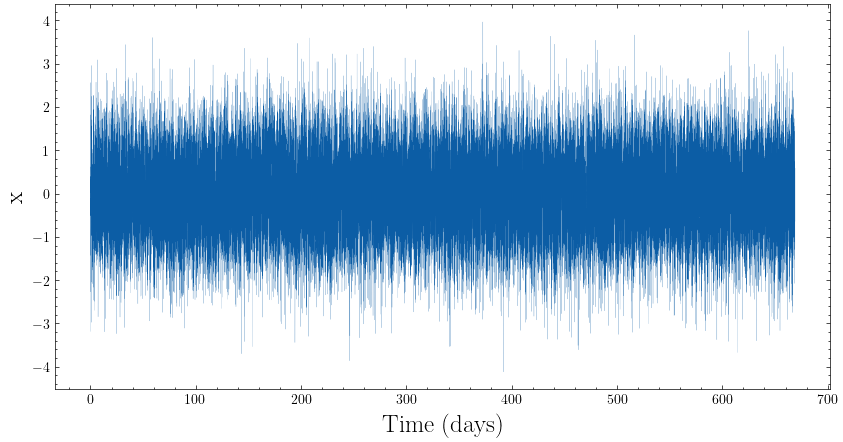

In [5]:
fig = plt.figure(figsize=(10, 5))
plt.plot(t.to(u.d).value, x, lw=0.1);
plt.ylabel(r'x', fontsize=fs);
plt.xlabel(r'Time (days)', fontsize=fs);

In [ ]:
fft = np.fft.fft(x)

vals = np.linspace(-5e-2, 5e-2, 1000) # Values at which to evaluate Gaussian PDF

# Frequency bin-width, for normalisation purposes
freq_bw = 1e6 / ((t.max() - t.min())*86400.0)

freq = np.fft.fftfreq(len(x), d=dt) # Taking only positive frequencies

fft_real = np.sqrt(2)*fft.real/len(x) # Divide by length of timeseries to normalise appropriately
fft_imag = np.sqrt(2)*fft.imag/len(x)


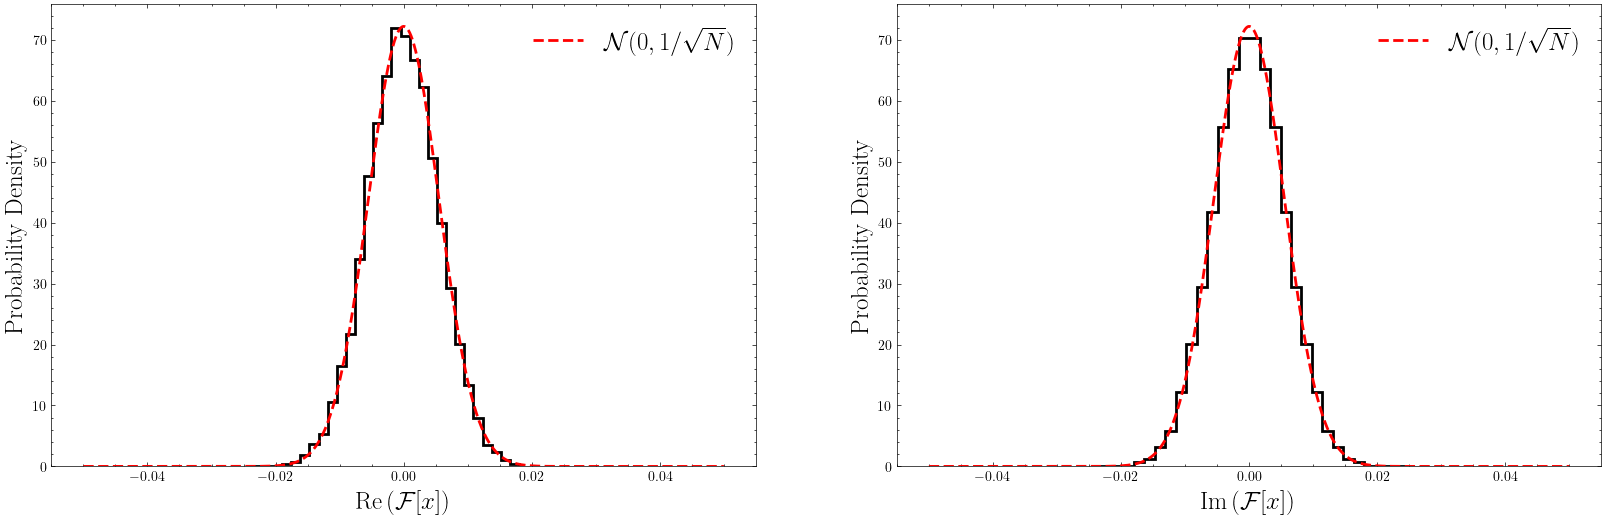

In [6]:

fig, ax = plt.subplots(figsize=(20, 6), nrows=1, ncols=2)
ax[0].hist(fft_real, bins=30, density=True, histtype='step', lw=2, color='k');
ax[0].plot(vals, scipy.stats.norm(loc=0, scale=1/np.sqrt(len(x))).pdf(vals), color='r', linestyle='--', lw=2, label=r'$\mathcal{N}(0, 1/\sqrt{N})$')
ax[0].set_xlabel(r'$\mathrm{Re}\left(\mathcal{F}[x]\right)$', fontsize=fs);
ax[0].set_ylabel(r'Probability Density', fontsize=fs);
ax[0].legend(loc='best', fontsize=fs);
ax[1].hist(fft_imag, bins=30, density=True, histtype='step', color='k', lw=2);
ax[1].plot(vals, scipy.stats.norm(loc=0, scale=1/np.sqrt(len(x))).pdf(vals), color='r', linestyle='--', lw=2, label=r'$\mathcal{N}(0, 1/\sqrt{N})$')
ax[1].set_xlabel(r'$\mathrm{Im}\left(\mathcal{F}[x]\right)$', fontsize=fs);
ax[1].set_ylabel(r'Probability Density', fontsize=fs);
ax[1].legend(loc='best', fontsize=fs);

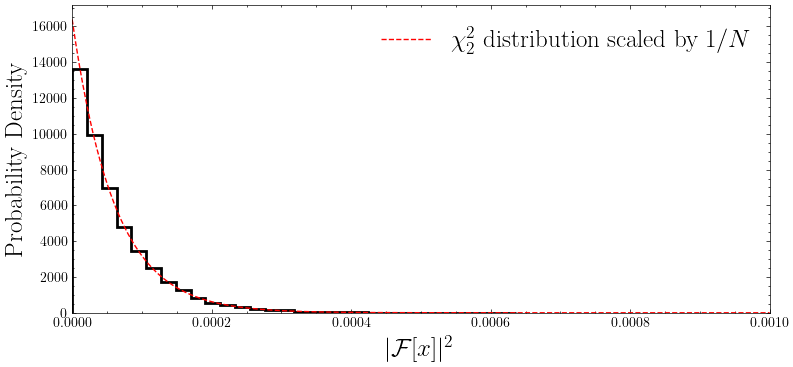

In [7]:
power = 2 * np.abs(fft)**2 / len(x)**2
vals = np.linspace(0, 1e-3, 1000)

plt.figure(figsize=(9, 4))
plt.hist(power, bins=30, histtype='step', density=True, color='k', lw=2);
plt.plot(vals, scipy.stats.chi2(df=2, scale=1/len(x)).pdf(vals), color='r', linestyle='--', label=r'$\chi^{2}_{2}$ distribution scaled by $1/N$');
plt.xlabel(r'$|\mathcal{F}[x]|^{2}$', fontsize=fs);
plt.ylabel(r'Probability Density', fontsize=fs);
plt.xlim(0, 1e-3);
plt.legend(loc='best', fontsize=fs);

Notice how the range of the distributions have now drastically changed -- this is because the random variates no longer have unit variance. To generalize our formulation of power spectrum statistics, we require describing the statistics of __unnormalized__ Gaussian random variates.

## Dealing with unnormalized Gaussian random variates

Given $u$, our unnormalized variable, we wish to map it to a normalized variable $x$ so that we can apply our formulation of $\chi^2$ statistics seen earlier. We divide $u$ by its root mean square (or standard deviation if the distribution is mean-centered) $s$, noting that this is effectively a change of variable for function $f(x)$ in Eqn. {eq}`chi2`:
```{math}
:label: changevar
\begin{aligned}
x=\frac{u}{s}, \quad g(u) = f\bigg(\frac{u}{s}\bigg)\frac{dx}{du}.
\end{aligned}
```
Making the substitution, we obtain the following probability density for the unnormalized variable $u$:
```{math}
:label: unnorm_chi2
\begin{align}
    g(u) &= \frac{1}{2^{n/2}\Gamma(n/2)}\frac{u^{n/2 - 1}}{s^{n/2}} \exp\bigg(-\frac{u}{2s}\bigg), \\
      &= \frac{1}{\Gamma(n/2)}\frac{u^{n/2 - 1}}{S^{n/2}} \exp\bigg(-\frac{u}{S}\bigg).
\end{align}
```
where a convenient substitution $S=2s$ is made in the last line. The quantity $S$ is the mean of the unnormalized $\chi^2_2$ distribution and is commonly taken as the mean of the white noise power spectrum.

```{note}
The mean of a $\chi^2_k$ distribution is $k$, with $k=2$ for the case of the Fourier transform. Since the two components of the Fourier transform are both equally scaled by $s$, their sum of squares results in a distribution whose mean is simply scaled by $2s$. 
```
Finally, by setting $n=2$ as our degrees of freedom, we obtain:
```{math}
:label: exp_pdf
\begin{align}
    g(u) = \frac{1}{S}\,\exp\bigg(-\frac{u}{S}\bigg). \\
\end{align}
```
This negative exponential distribution is the probability density function describing the distribution of power $x_i$ at a specific frequency ($i$) in a power spectrum when the underlying signal follows a $\chi_2^2$ dof distribution. Compare this with the formulation presented by {cite}`Duvall_1986` and {cite}`Anderson_1990`:
```{math}
:label: psd_dist
\begin{align}
    p(x_{i}) = \frac{1}{\langle x_{i}\rangle}\exp\left(-\frac{x_{i}}{\langle x_{i}\rangle}\right),
\end{align}
```
where $\langle x_{i}\rangle$ is the expectation value of the power spectrum at a particular frequency, also known as the ***limit spectrum***. 

In cases where the limit spectrum is normalized to have a white noise level of unity (i.e., $S=1$), Eqn {eq} `unnorm_chi2` is simplified to:
```{math}
:label: unnorm_chi2_mean
\begin{align}
    g(u) &= \frac{1}{\Gamma(n/2)}u^{n/2 - 1} \exp(-u),
\end{align}
```
which is an expression commonly presented in statistical detection tests.

```{admonition} Fourier transform symmetry
:class: seealso

The computation of the Fourier transform generates a two-sided frequency spectrum, where the negative frequencies are simply a mirror image of the positive ones. In practice, we simply discard the negative frequencies, with the power in those frequencies simply assigned towards to their positive counterparts. How should we modify `scipy.stats.chi2` to recover the same distribution as shown above?
:::{hint}
:class: dropdown
The reassignment simply doubles the power in the positive frequencies range, so scale the $\chi^2$ distribution accordingly.
:::
```

To confirm the equivalence of Eqns. {eq}`chi2`: and {eq}`unnorm_chi2`, we run the following, paying special attention that the distribution is now more easily parameterized by a **Gamma** distribution, using `scipy.special.gamma`.

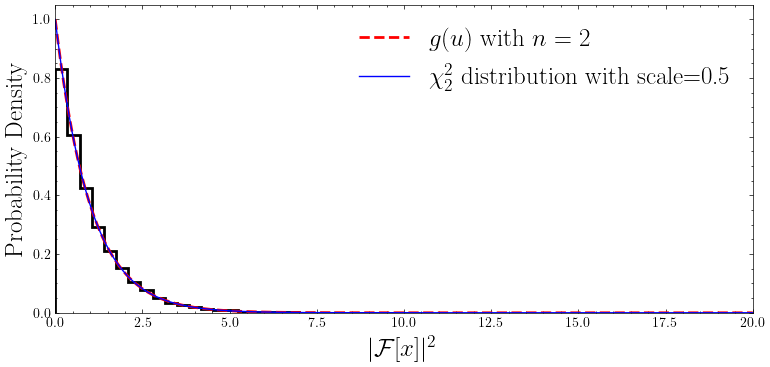

In [8]:
power = 2 * np.abs(fft)**2 / len(x)**2
power = power[:len(x)//2] # see the Above tip!
freq = freq[:len(x)//2]
power[1:] *= 2


vals = np.linspace(0, 20, 1000)
dof = 2
dist = (1/scipy.special.gamma(dof/2)) * (vals)**(dof/2 - 1) * np.exp(-vals)

plt.figure(figsize=(9, 4))
plt.hist(power/np.mean(power), bins=30, histtype='step', density=True, color='k', lw=2);
plt.plot(vals, dist, color='r', linestyle='--', label=r'$g(u)$ with $n=2$', lw=2);
plt.plot(vals, scipy.stats.chi2(df=2, scale=1/2).pdf(vals), color='blue', linestyle='-', 
         label=r'$\chi^{2}_{2}$ distribution with scale=0.5');
plt.xlabel(r'$|\mathcal{F}[x]|^{2}$', fontsize=fs);
plt.ylabel(r'Probability Density', fontsize=fs);
plt.xlim(0, 20);
plt.legend(loc='best', fontsize=fs);

We see that the two are indeed equivalent.

```{tip}
The $\chi^2$ distribution is a special case of the Gamma distribution, with Gamma parameters a = dof/2, loc = 0 and scale = 2. Equivalently, setting scale=0.5 for `scipy.stats.chi2` provides the form of the Gamma distribution.
```
`````{admonition} Exercise
:class: dropdown
Verify that Eqn. {eq}`chi2` conforms to the probability distribution function of a Gamma distribution. What are the shape parameters $k$ and $\theta$? Given that the mean of a Gamma distribution is $k\theta$, what is the expected value of Eqn. {eq}`chi2`?
`````

## Statistics of a Binned Power Spectrum

When dealing with long, continuous time series comprising $N\sim10^5-10^6$ timestamps, it can often be beneficial to bin their the power spectrum to average out noise and to reduce computational burden, as the number of frequency bins scales with $1/N$. What are the statistics when we average over $p$ independent frequency bins? 

Because the sum of $p$ random variables drawn from a $\chi^2_2$ distribution results in a $\chi^2_{2p}$ distribution, we can determine the mean of this resulting distribution to be simply $p\times \text{Mean of}\chi^2_2$ distribution. In other words, we are simply considering a $\chi^2_2$ distribution scaled by a factor $s$, which is exactly the same as we had done in {eq}`changevar` with a normalization (i.e., $u=x/s$)! Therefore, beginning with {eq}`unnorm_chi2`, we have:
```{math}
:label: binned_chi2_one
\begin{align}
    g(u) &= \frac{1}{\Gamma(n/2)}\frac{u^{n/2 - 1}}{S^{n/2}} \exp\bigg(-\frac{u}{S}\bigg),    
\end{align}
```
Since we have $n=2p$, and we are scaling the independent variable by $p$. We thus change the variable in {eq}`binned_chi2_one` again by setting 
```{math}
:label: binned_chi2_two
\begin{align}
    v &= \frac{u}{p},
\end{align}
```
where $v$ indicates the binned frequency bins. This yields the following distribution:
```{math}
:label: binned_chi2_three
\begin{align}
    h(v) &= \frac{p^p}{\Gamma(p)}\frac{v^{p-1}}{S^p}\exp\bigg(-\frac{vp}{S}\bigg).
\end{align}
```

```{note}
Here, we no longer assume $S=1$ as before because the binned spectrum may have a mean value different from unity.
```

We can check this by binning our computed white noise power spectrum into $N=1000$ chunks (which is equivalent to averaging over 16 independent frequency bins per chunk) and looking at the distribution of the binned power.

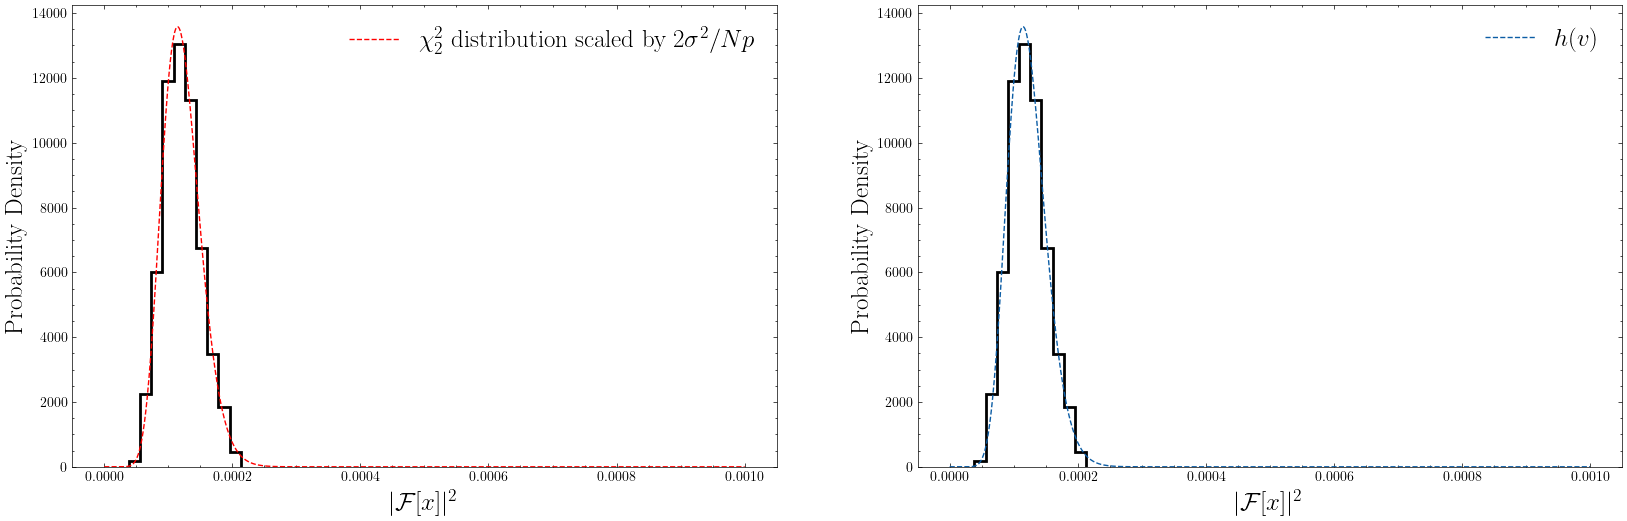

In [12]:
def rebin_data(x, y, n_bins, statistic='mean'):
    """
    Bin the data into a given number of bins.

    Inputs:

        :parameter x: x array to rebin (e.g. frequency).
        :type x: array

        :parameter y: y array to rebin (e.g. power).
        :type y: array

        :parameter n_bins: Number of bins to bin the data into.
        :type n_bins: array

    """
    # Bin the data
    binned_data  = scipy.stats.binned_statistic(
                    x         = x,
                    values    = y,
                    statistic = statistic,
                    bins      = n_bins)
    bin_edges = binned_data[1]
    bin_width = (bin_edges[1] - bin_edges[0])

    return bin_edges[1:] - bin_width/2, binned_data[0]

n_bins = 1000
rebinned_freq, rebinned_power = rebin_data(freq, power, n_bins=n_bins)
binned_dof = len(power) / n_bins

vals = np.linspace(0, 1e-3, 1000)

scale = 2/(len(x)) # factor of 2 from FT normalization

# Don't forget this, our change of variable, S=2s as before!
S = 2 * scale

dist = (binned_dof**(binned_dof))*(1/scipy.special.gamma(binned_dof)) * (vals)**(binned_dof - 1)/(S**binned_dof) * np.exp(-binned_dof*vals/S)

fig, ax = plt.subplots(figsize=(20, 6), nrows=1, ncols=2)
ax[0].hist(rebinned_power, bins=10, histtype='step', density=True, color='k', lw=2);
ax[0].plot(vals, scipy.stats.chi2(df=2*binned_dof, scale=scale/binned_dof).pdf(vals), color='r', linestyle='--', label=r'$\chi^{2}_{2}$ distribution scaled by $2\sigma^{2}/Np$');
ax[0].set_xlabel(r'$|\mathcal{F}[x]|^{2}$', fontsize=fs);
ax[0].set_ylabel(r'Probability Density', fontsize=fs);
ax[0].legend(loc='best', fontsize=fs);

ax[1].hist(rebinned_power, bins=10, histtype='step', density=True, color='k', lw=2);
ax[1].plot(vals, dist, linestyle='--', color='C0', label=r'$h(v)$');
ax[1].set_xlabel(r'$|\mathcal{F}[x]|^{2}$', fontsize=fs);
ax[1].set_ylabel(r'Probability Density', fontsize=fs);
ax[1].legend(loc='best', fontsize=fs);

These are indeed equivalent, providing us a useful approach for calculating the statistics of a binned spectrum.

## Further Reading


[[1]](https://ui.adsabs.harvard.edu/abs/2003A%26A...412..903A/abstract) Appourchaux, T., “On Maximum Likelihood Estimation of averaged power spectra”, <i>Astronomy and Astrophysics</i>, vol. 412, pp. 903–904, 2003. doi:10.1051/0004-6361:20034401.

[[2]](https://ui.adsabs.harvard.edu/abs/2004A%26A...428.1039A/abstract) Appourchaux, T., “On detecting short-lived p modes in a stellar oscillation spectrum”, <i>Astronomy and Astrophysics</i>, vol. 428, pp. 1039–1042, 2004. doi:10.1051/0004-6361:20041682.